In [1]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas
from datapipe import bin_ndarray
from skimage import io

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Input, Dense, Flatten, GlobalAveragePooling2D, Conv1D,Conv2D, MaxPooling2D,MaxPooling1D, Dropout, UpSampling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
def cropImage(imArr):
    (length, x, y, channel) = imArr.shape
    cropped = np.zeros((length, x+2, y, channel))
    for ind, im in enumerate(imArr):
        for rowind, row in enumerate(im):
            cropped[ind][rowind] = row.reshape(y,1)
    return cropped

In [4]:
eye = io.imread('./data/eye_AV2.tif')
np.random.seed(42)
(length, lenx, leny) = eye.shape
print(eye.shape)
print(lenx,leny)

(53232, 62, 84)
62 84


In [5]:
#though I was going to do multiple in this file but maybe if I have multiple 
data =eye

In [6]:
num_data = len(data)
train_split = 0.8
num_train = int(train_split*num_data)
num_test = num_data - num_train
x_train = data[0:num_train].reshape(num_train, (lenx*leny))
x_test = data[(num_train):].reshape(num_test, (lenx*leny))

In [7]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
x_test_scaled = x_scaler.transform(x_test)

In [9]:
input_img = Input(shape=(lenx+2, leny, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(62, (2, 2), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 3), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(16, (2, 2), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 3))(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (2, 2), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [10]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 84, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 84, 62)        310       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 42, 62)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 42, 32)        7968      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 21, 16)        2064      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 7, 16)          0         
__________

In [11]:
print(lenx,leny)
x_train = np.ndarray.astype(x_train_scaled.reshape((num_train, lenx,leny,1)), np.float16)
x_test = np.ndarray.astype(x_test_scaled.reshape((num_test, lenx, leny, 1)), np.float16)
x_train = cropImage(x_train)
x_test = cropImage(x_test)
print(x_train.shape)

62 84
(42585, 64, 84, 1)


In [12]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [13]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [14]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [15]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [16]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]
print(x_train.shape)

(42585, 64, 84, 1)


In [19]:
%%time
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

Train on 42585 samples, validate on 10647 samples
Epoch 1/20
42585/42585 [==============================] - 80s 2ms/step - loss: 0.4568 - val_loss: 0.4439

Epoch 00001: val_loss did not improve from 0.44392
Epoch 2/20
42585/42585 [==============================] - 75s 2ms/step - loss: 0.4568 - val_loss: 0.4439

Epoch 00002: val_loss improved from 0.44392 to 0.44392, saving model to 23_checkpoint.keras
Epoch 3/20
42585/42585 [==============================] - 75s 2ms/step - loss: 0.4568 - val_loss: 0.4439

Epoch 00003: val_loss improved from 0.44392 to 0.44392, saving model to 23_checkpoint.keras
Epoch 4/20
42585/42585 [==============================] - 75s 2ms/step - loss: 0.4568 - val_loss: 0.4439

Epoch 00004: val_loss improved from 0.44392 to 0.44392, saving model to 23_checkpoint.keras
Epoch 5/20
42585/42585 [==============================] - 82s 2ms/step - loss: 0.4568 - val_loss: 0.4439

Epoch 00005: val_loss did not improve from 0.44392
Epoch 6/20
42585/42585 [==================

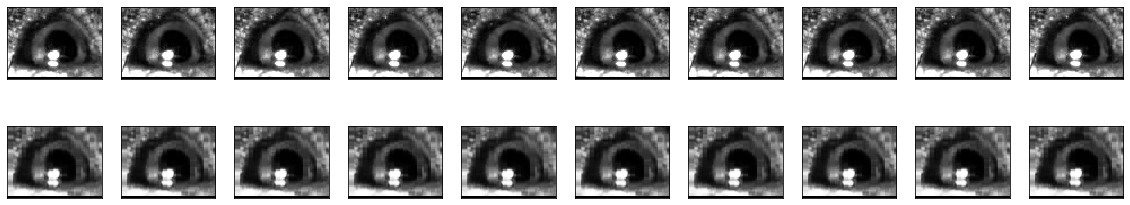

In [22]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i+600].reshape(lenx+2, leny))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i+600].reshape(lenx+2, leny))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [23]:
autoencoder.save('eyeEncoder2.h5')